In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import lqr, dare
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Particle

In [8]:
p = 0
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6e-6
eta_detection = 1
delta_t = 1e-9
control_step = 30 # defined as int, number of time steps of simulation necessary to compute the control policy
fs = 1/(control_step*delta_t)

In [9]:
gamma, omega, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist, 
                                                                      radius, p, fs, eta_detection)
gamma, omega, ba_force**2, std_detection**2, std_z

(0.0,
 501266.40589032974,
 5.237976008129461e-41,
 3.538644164320225e-21,
 1.4571158150923128e-14)

In [10]:
#fs*ba_force**2, (env.zp_p*env.backaction_std)**2

In [92]:
std_z

1.4571158150923128e-14

In [93]:
period = 2*np.pi/omega
t = np.arange(0, 20 * period, delta_t)
N = t.shape[0]

In [94]:
coupling = (1/(4*np.pi))*(ba_force**2)
coupling

4.1682488674527876e-42

In [95]:
env = Particle(omega, gamma, coupling, radius=radius, eta_detection=1, T=293)

In [96]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = std_detection/env.zp_x
std_detection, variance_process

(11.436084942324618, 509746.1989570866)

In [97]:
Q = np.array([[0, 0], [0, variance_process]])*control_step*delta_t/2
R = np.array([[np.power(std_detection,2)]])

In [98]:
g_fb = 2*omega
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0],
                        [0, omega/2]])
(G_lqr, S, E) = lqr(env.A, env.B, cost_states, omega/(g_fb**2))
X, L, G = dare(Ad, Bd, cost_states, omega/(g_fb**2))
G_lqr, G

(array([[366952.47723914, 932961.9060523 ]]),
 array([[347941.326902  , 925347.79994767]]))

In [111]:
x0 = 0
P0 = 3e8*np.matrix(np.eye(2))
estimation = np.matrix([[x0*np.random.normal()], [x0*np.random.normal()]])
states = np.array([[x0*np.random.normal()], [x0*np.random.normal()]])
new_states = np.zeros((N, 2))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0, :] = estimation.reshape((2))
estimation = estimation.reshape((2, 1))
control = np.array([[0]])
controls = []
kalman = KalmanFilter(estimation, P0, Ad, Bd, env.C, Q, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[0, 0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((2))
        estimation = estimated_states[i, :].reshape((2, 1))
        control = -np.matmul(G, estimation)
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
    controls.append(float(control))
    states = env.step(states, control=control, delta_t=delta_t)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 250693/250693 [00:12<00:00, 19934.06it/s]


In [112]:
def compute_phonons(estimations, cov_matrix, step=100):
    sampled_cov_matrix = cov_matrix[::step]
    N = len(sampled_cov_matrix)
    phonons = np.zeros((N-1))
    for i in range(1, N):
        averaged = estimations[(i-1)*step:i*step, :].mean(axis=0)
        second_moments = sampled_cov_matrix[i]+np.power(averaged,2)
        phonons[i-1] = np.trace(second_moments)/4-0.5
    return phonons

In [113]:
len(kalman.error_covariance_aposteriori), estimated_states[::control_step,:].shape

(8358, (8357, 2))

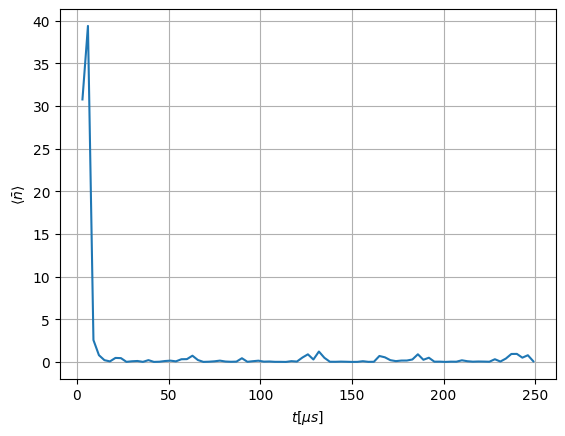

In [114]:
step=100
phonons = compute_phonons(estimated_states[::control_step, :], kalman.error_covariance_aposteriori, step=step)
plt.plot(t[::control_step][::step][1:]/1e-6, phonons)
#plt.xlim([t[::control_step][::step][1]/1e-6, t[::control_step][::step][-1]/1e-6])
#plt.ylim([0,20])
plt.ylabel(r'$\langle \bar{n} \rangle$')
plt.xlabel(r'$t[\mu s]$')
plt.grid()
plt.show()

In [123]:
phonons[-50:].mean()

0.2583621119924377

In [76]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
np.sqrt(cov_mat), estimated_states[-1,:].T

(matrix([[1.58987047, 0.69905426],
         [0.69905426, 1.65285567]]),
 array([-0.37695558,  1.31049347]))

In [35]:
second_moments = cov_mat+np.power(estimated_states[::30][8000:,:].mean(axis=0),2)
nbar = compute_phonon(second_moments)
nbar

0.528004019583955

In [429]:
-0.5+np.trace(cov_mat+np.power(estimated_states[1000:,:].mean(axis=0),2))/2
-0.5+(cov_mat+np.power(estimated_states[10000:,:].mean(axis=0),2))

matrix([[ 1.30538671, -0.23727487],
        [-0.25053753,  1.39497016]])

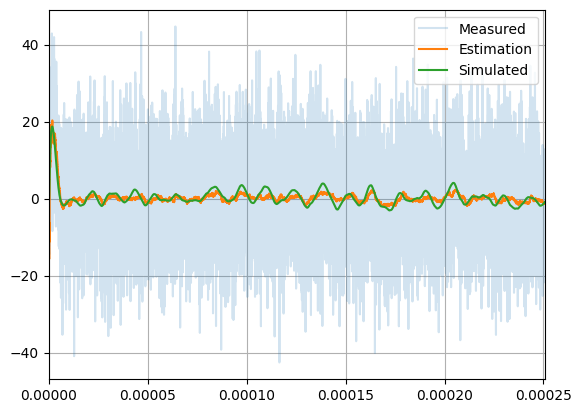

In [104]:
plt.plot(t[:], measured_states[:], alpha=0.2)
plt.plot(t[:], estimated_states[:,0])
plt.plot(t[:], new_states[:,0])
#plt.ylim([-10, 10])
plt.xlim([t[0], t.max()])
#plt.title(r'$\lange n \rangle = $')
plt.legend(['Measured', 'Estimation', 'Simulated'])
plt.grid()

In [417]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])


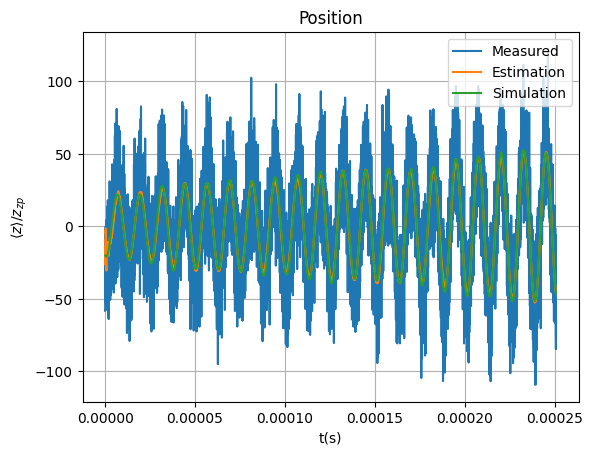

In [418]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, measured_states)
plt.plot(t[100:], estimated_states[100:,0])
plt.plot(t[100:], new_states[100:,0])
plt.legend(['Measured', 'Estimation', 'Simulation'], loc='upper right')
plt.xlabel(r't(s)')
plt.ylabel(r'$\langle z\rangle/z_{zp}$')
plt.grid()
plt.show()

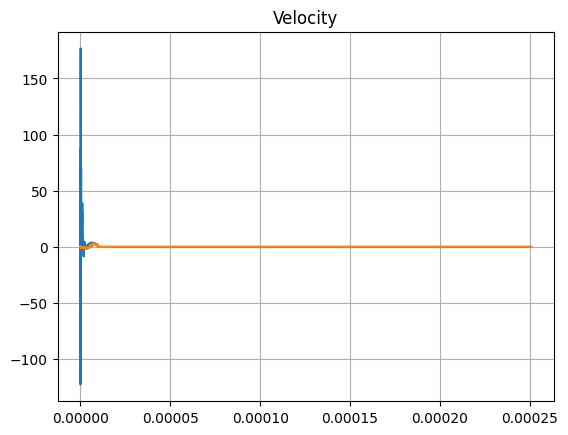

In [266]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t[:], estimated_states[:,1])
plt.plot(t[:], new_states[:,1])
plt.grid()
plt.show()

In [18]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [87]:
df = pd.DataFrame()
df['z'] = butter_bandpass_filter(estimated_states[:,0][::30], 22e3, 220e3, 1/(30e-9), order=2)[500:]
df['p'] = butter_bandpass_filter(estimated_states[:,1][::30], 22e3, 220e3, 1/(30e-9), order=2)[500:]

(-3.797461615078562, 4.12234273565336)

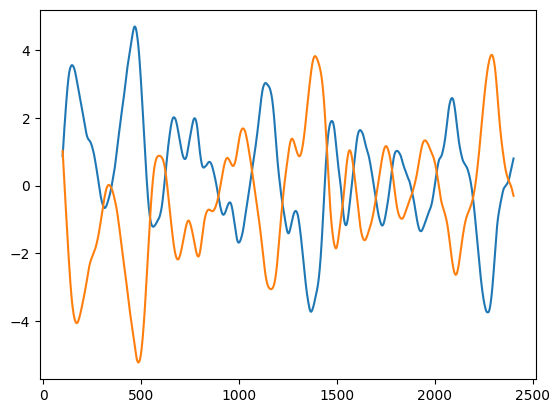

In [88]:
plt.plot(df['z'][100:])
plt.plot(df['p'][100:])
df['z'].values[0], df['p'].values[0]

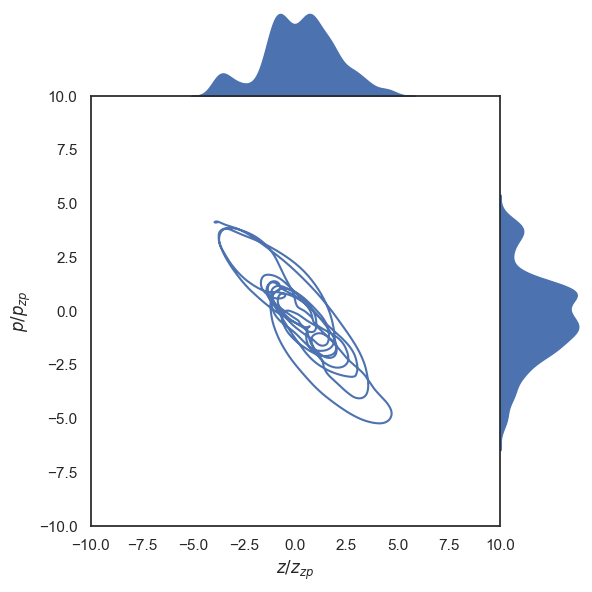

In [89]:
sns.set_theme(style="white")
g = sns.JointGrid(data=df, x="z", y="p", space=0, xlim=[-10,10], ylim=[-10,10])
g.plot_joint(sns.lineplot, sort = False)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')

In [71]:
(1/np.sqrt(delta_t))*1.76*np.sqrt(4e-28)/env.zp_x

587.1995258653128

In [72]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
np.sqrt(cov_mat)

matrix([[1.79740127, 2.33030486],
        [2.33030486, 4.70860611]])

In [73]:
estimated_states[-30:].var(axis=0)

array([0.00626425, 0.01276558])

In [418]:
(env._m_*np.power(env.__omega__, 2)*np.power(z_std,2)+np.power(p_std,2)/env._m_)/(2*ct.hbar*env.__omega__)

1.2180144935641593

In [419]:
z_std*p_std > ct.hbar/2

True